100%|██████████| 9.91M/9.91M [00:00<00:00, 54.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.68MB/s]


Epoch 1, Loss: 163.70
Epoch 2, Loss: 121.14
Epoch 3, Loss: 114.41
Epoch 4, Loss: 111.55
Epoch 5, Loss: 109.81
Epoch 6, Loss: 108.68
Epoch 7, Loss: 107.81
Epoch 8, Loss: 107.20
Epoch 9, Loss: 106.69
Epoch 10, Loss: 106.25


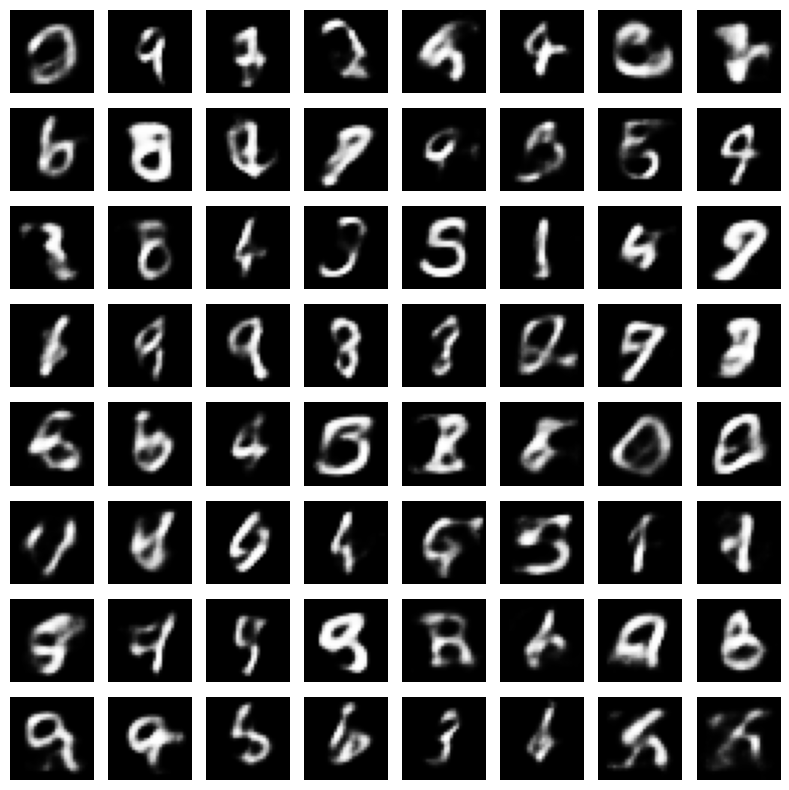

In [ ]:
#Variational Autoencoder (VAE)
# STEP 1: Install required packages
!pip install torch torchvision matplotlib --quiet
# STEP 2: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
# STEP 3: Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# STEP 4: Define Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_decode(z))
        return torch.sigmoid(self.fc_out(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
# STEP 5: Define loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
# STEP 6: Train the VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for images, _ in train_loader:
        images = images.view(-1, 784).to(device)
        recon, mu, logvar = vae(images)
        loss = loss_function(recon, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.2f}")
# STEP 7: Generate new digits from the latent space
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    generated = vae.decode(z).cpu()
    generated = generated.view(64, 1, 28, 28)
# STEP 8: Plot generated digits
def plot_images(images, n_row=8):
    images = images.numpy()
    fig, axes = plt.subplots(n_row, n_row, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, 0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(generated)